# Cleaning WW1 Data
To clean the WW1 data, we will be removing the unneeded columns using pandas.

In [ ]:
!pip install datasets
!pip install ipympl

from datasets import load_dataset
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.0 MB/s eta 0:00:00


In [ ]:
ww1_data = load_dataset("dell-research-harvard/AmericanStories",
    "subset_years",
    year_list = ['1918']
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for dell-research-harvard/AmericanStories contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dell-research-harvard/AmericanStories
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the 

Only taking a subset of years. Change name to 'all_years' to use all years in the dataset.
{'1918': 'https://huggingface.co/datasets/dell-research-harvard/AmericanStories/resolve/main/faro_1918.tar.gz'}


Generating 1918 split: 0 examples [00:00, ? examples/s]

Loading associated


# Removing Columns

In [ ]:
# Convert dataset to pandas Dataframe
ww1_df = ww1_data['1918'].to_pandas()

# Specify columns to remove
ww1_removed = ['newspaper_name', 'edition', 'page', 'headline', 'byline']

# Remove columns
ww1_df.drop(columns = ww1_removed, inplace=True)

# Print
print(ww1_df.head())

## Finding Similarity

In [ ]:
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
# Establish keywords -- in this case, explicit slurs
racist_keywords = ['kraut', 'hun', 'boche']

# Establish seed words
seed_words = ['racism', 'prejudice', 'discrimination']

In [ ]:
# Find an Article
documents = print(ww1_data['1918'][0]['article'])
documents = [article['article'] for article in ww1_data['1918']]

Windham, Levi, Daniel and Charles of this city, and a sister, Mrs. Betsy B. Andrews of North Windham.

 Mrs. Mary J. Fuller, wife of Joseph c. Fuller died at her home in Mans field Four Corners, late Thursday afternoon.

 She was born in Portland, Conn. February '. 1S4S. the daughter of Thomas and Catherine (Raney) Hub bard. She was of very kindly n1- ture and leaves a large circle of friends. She is survived by two sons, Charles J. Fuller of Westerly and Sergeant Irving Fuller, a member of the marines now in france. He was the first Mansfield boy to enter the service and has been wounded three times. She is also survived by three daughters, Mrs. I. P. Phelps of West Upton, Mass, and the Misses Minnie L. Fuller of Mansfield, and A1lieen Full Ter of Hartford.

 Mrs. Bertha LoiseIle Hurley, wife o1 William T. Hurley. died at her home at 19 Bellevue steeet. Thursday aft ernoou at 4.30, from pneumonia. She was born in Canada, January 23 1884, the daughter of Napoleon and Nelnia Loiselle. S

Similarities for prejudice:
  kraut: -0.018778663128614426
  hun: 0.22786381840705872
  boche: 0.10712743550539017
Similarities for discrimination:
  kraut: -0.06699907779693604
  hun: 0.133522167801857
  boche: -0.0033246560487896204


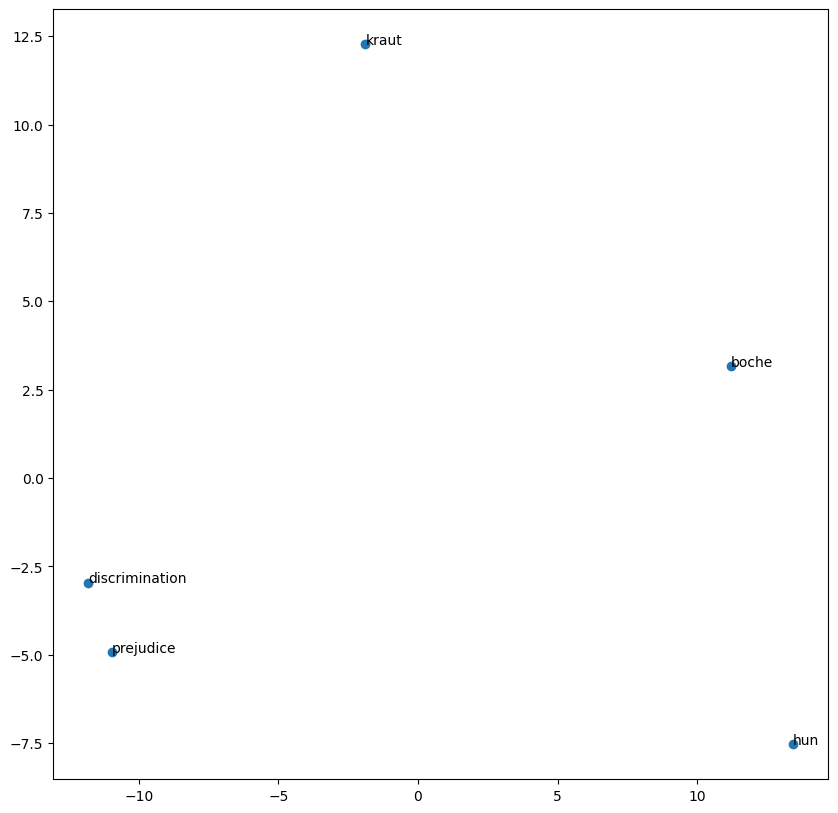

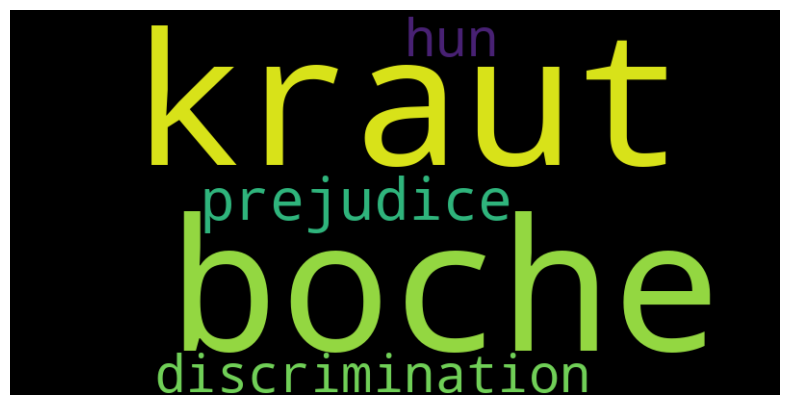

In [ ]:
processed_docs = [gensim.utils.simple_preprocess(doc) for doc in documents]

# Train the Word2Vec model
model = Word2Vec(processed_docs, vector_size=100, window=5, min_count=1, workers=4)

# Find similarities between seed words and racist keywords
similarity_results = {}

for seed_word in seed_words:
    if seed_word in model.wv:
        similarities = {}
        for keyword in racist_keywords:
            if keyword in model.wv:
                similarity = model.wv.similarity(seed_word, keyword)
                similarities[keyword] = similarity
        similarity_results[seed_word] = similarities

# Print similarity results
for seed_word, similarities in similarity_results.items():
    print(f"Similarities for {seed_word}:")
    for keyword, similarity in similarities.items():
        print(f"  {keyword}: {similarity}")

# Flatten the list of words to visualize
words = list(set(seed_words + racist_keywords))

# Check if words list is empty
if not words:
    print("No words to visualize")
else:
    # Filter words to ensure they are in the model vocabulary
    words_in_vocab = [word for word in words if word in model.wv]

    if not words_in_vocab:
        print("None of the words are in the model vocabulary")
    else:
        word_vectors = model.wv[words_in_vocab]

        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(word_vectors)

        plt.figure(figsize=(10, 10))
        plt.scatter(pca_result[:, 0], pca_result[:, 1])

        for i, word in enumerate(words_in_vocab):
            plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]))

        plt.show()

        # Generate a word cloud for one of the seed words
        wordcloud = WordCloud(width=800, height=400).generate(' '.join(words_in_vocab))

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()